In [68]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument
# Load the TensorBoard notebook extension
%load_ext tensorboard

import sys
sys.path.insert(0,'..')

# https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification

from GPUtil import showUtilization as gpu_usage
gpu_usage()                             


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
| ID | GPU | MEM |
------------------
|  0 |  0% |  8% |


In [69]:
pip install torchviz



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [70]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import RandomSampler

from matplotlib import pyplot as plt

from src.caption import Caption
from src.baseline.coa_model import save_model, load_model, train_validate_test_split
from src.baseline.data_loader import get_mean, get_std


import torch
import gc
# from GPUtil import showUtilization as gpu_usage


## shared code

In [71]:
# essential functions 
def creat_caption_file(filename,columns='image,labels,psum,psum_sq'):
    f = open(filename, "w+")
    f.write(columns)
    f.write('\n')
    f.close()

def write_line_to_file(filename, line):
    with open(filename, 'a') as f:
        f.write(line)
        f.write('\n')
    f.close()

In [72]:
# extract the main info from the label into three columns 

def write_break_down_columns(old_caption_file, new_caption_file):
    with open(old_caption_file, 'r') as f:
        for line in f:
            # skip title
            if 'image,caption,psum,psum_sq' in line:
                continue

            image_name, text_label,psum,psum_sq = line.split(',')
            text_label = text_label.strip()

            struc_label = Caption(text_label, support_plural=True).get_structured()
            first_object = struc_label['objects'][0]
            mod =  first_object['modifiers'][0] if len( first_object['modifiers']) > 0 else ""
            write_line_to_file(new_caption_file, f"{image_name},{first_object['charge']},{mod},{first_object['color']},{psum},{psum_sq}")


In [73]:
# write back the class number to the annotiation file
def get_image_class(item, classes_map):
    for k,v in classes_map.items():
        if v == item:
            return k
    return None
    
def write_class_colum(df, with_class_caption_file, classes_map):
    for _,line in df.iterrows():
        image_name,charge,mod,color,psum,psum_sq = line['image'],line['charge'],line['mod'],line['color'],line['psum'],line['psum_sq']
        image_class = get_image_class((charge, mod, color),classes_map)

        write_line_to_file(with_class_caption_file, f"{image_name},{charge},{mod},{color},{psum},{psum_sq},{image_class}")


In [74]:
import os
import torch
import pandas as pd
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from src.baseline.vocabulary import Vocabulary
import torchdatasets as td
from src.utils import print_time
from pathlib import Path


class CoAClassDataset(td.Dataset):

    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5, vocab=None, device="cpu", calc_mean=False):
        super().__init__()  # for the td.Dataset
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.df = pd.read_csv(captions_file)
        self.calc_mean = calc_mean

        # Get image and caption colum from the dataframe
        self.img_names = self.df["image"]
        self.classes = self.df["class"]

        # Get pixels colum from the dataframe
        try:
            self.psum = self.df["psum"]
        except IndexError:
            print('no pixels sum column')

        try:
            self.psum_sq = self.df["psum_sq"]
        except IndexError:
            print('no squared pixels sum column')


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Read the image and return needed information to 
        be used later by the loader

        Args:
           idx(int): index of the image we want to read in the list

        Returns:
            tensor: image tensor 
            string: image class
            float: sum of the pixels -> to calculate the mean 
            float: squared sum of the pixels -> to calculate the std
            string: image file name 
        """
        if self.calc_mean == True:
            return torch.tensor([]), torch.tensor([]), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
        else:
            try:
                return self._get_image_tensor(idx), self._get_label_class(idx), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
            except TypeError or IndexError:
                print(f' Error, cannot find image with index: {str(idx)}')

    def _get_image_tensor(self, idx):
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)

        my_image = Path(img_location)
        if not my_image.exists():
            print(f'skipping image {img_name}, as it does not exist')

        img = Image.open(img_location).convert("RGB")
#         print(img)
        # apply the transfromation to the image
        if self.transform is not None:
#             print('self.transform is not None')
            img_t = self.transform(img)
        else:
            trans = T.ToTensor()
            img_t = trans(img)
#         print('img_t: ',img_t)

        return img_t

    def _get_label_class(self, idx):
        
        label_class = self.classes[idx]
#         if self.transform is not None:
#             label_class_t = self.transform(label_class)
#         else:
#             trans = T.ToTensor()
#             label_class_t = trans(label_class)

        return label_class

    



In [75]:
def visualize_one_batch(data_loader):
    # Visualize one training batch
    for images,classes,_,_,_ in data_loader:
        print(type(classes))
        fig, ax = plt.subplots(figsize = (25, 25))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 5).permute(1,2,0))
        break


In [76]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


In [87]:
### Training Code
def train_classification_model(model, optimizer, criterion, lr_scheduler, epochs, train_data_loader, val_data_loader, device):
    from tqdm import tqdm

    for epoch in range(epochs):
        start = time.time()

        #Epoch Loss & Accuracy
        train_epoch_loss = []
        train_epoch_accuracy = []
        _iter = 1

        #Val Loss & Accuracy
        val_epoch_loss = []
        val_epoch_accuracy = []

        # Training
        with tqdm(train_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
            for images, labels,_,_,_ in tepoch: 
                images = images.to(device)
                labels = labels.to(device)

                #Reset Grads
                optimizer.zero_grad()

                #Forward ->
                preds = model(images)

                #Calculate Accuracy
                acc = calc_accuracy(labels.cpu(), preds.cpu())

                #Calculate Loss & Backward, Update Weights (Step)
                loss = criterion(preds, labels)
                loss.backward()
                optimizer.step()
#                 lr_scheduler.step()
                
                #Append loss & acc
                loss_value = loss.item()
                train_epoch_loss.append(loss_value)
                train_epoch_accuracy.append(acc)

                tepoch.set_postfix({'train_epoch_loss': loss_value})
    #             tepoch.set_postfix({'train_epoch_accuracy',acc})

                if _iter % 500 == 0:
                    print("> Iteration {} < ".format(_iter))
                    print("Iter Loss = {}".format(round(loss_value, 4)))
                    print("Iter Accuracy = {} % \n".format(acc))

    #             _iter += 1

        # tryinf to free the memory
#         gc.collect()
#         torch.cuda.empty_cache()
#         gpu_usage()                             

        #Validation
        with tqdm(val_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for images, labels,_,_,_ in tepoch:
                images = images.to(device)
                labels = labels.to(device)

                #Forward ->
                preds = model(images)

                #Calculate Accuracy
                acc = calc_accuracy(labels.cpu(), preds.cpu())

                #Calculate Loss
                loss = criterion(preds, labels)

                #Append loss & acc
                loss_value = loss.item()
                val_epoch_loss.append(loss_value)
                val_epoch_accuracy.append(acc)
                tepoch.set_postfix({'val_epoch_loss': loss_value})
    #             tepoch.set_postfix({'val_epoch_accuracy',acc})


        train_epoch_loss = np.mean(train_epoch_loss)
        train_epoch_accuracy = np.mean(train_epoch_accuracy)

        val_epoch_loss = np.mean(val_epoch_loss)
        val_epoch_accuracy = np.mean(val_epoch_accuracy)

        end = time.time()

        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)

        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        #Print Epoch Statistics
        print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
        print("Train Loss = {}".format(round(train_epoch_loss, 4)))
        print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
        print("Val Loss = {}".format(round(val_epoch_loss, 4)))
        print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
    
    return model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy




In [78]:
def test_classification_model(model, test_data_loader):
    test_epoch_loss = []
    test_epoch_accuracy = []

    test_loss = []
    test_accuracy = []

    # model.eval()
    with torch.no_grad():
        for images, labels,_,_,_ in test_data_loader:
            print(type(labels))
            images = images.to(device)
            labels = labels.to(device)

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            test_epoch_loss.append(loss_value)
            test_epoch_accuracy.append(acc)

    test_epoch_loss = np.mean(test_epoch_loss)
    test_epoch_accuracy = np.mean(test_epoch_accuracy)

    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

    print("Test Loss = {}".format(round(test_epoch_loss, 4)))
    print("Test Accuracy = {} % \n".format(test_epoch_accuracy))



# Train on dataset with single object

## Data preprocessing 

In [16]:

MISSING_TOKEN = 'None'

In [17]:
# data_location =  '../baseline-gen-data/small/'
data_location =  '/home/salnabulsi/coat-of-arms/data/new/'
caption_file = data_location + 'test_real_captions_psumsq.txt'
new_caption_file = data_location + '/new-labels-psumsq.txt'




In [18]:
creat_caption_file(new_caption_file, 'image,charge,mod,color,psum,psum_sq')


In [19]:
write_break_down_columns(caption_file, new_caption_file)

ValueError (not raised): label "O G lion q.f." cannot be parsed. The chunk "q.f." cannot be fit into any category.
ValueError (not raised): label "O A cross botonny" cannot be parsed. The chunk "botonny" cannot be fit into any category.
ValueError (not raised): label "G A lion q.f." cannot be parsed. The chunk "q.f." cannot be fit into any category.
ValueError (not raised): label "O G cross fleuretty" cannot be parsed. The chunk "fleuretty" cannot be fit into any category.
ValueError (not raised): label "O S eagle per fess" cannot be parsed. The chunk "per" cannot be fit into any category.
ValueError (not raised): label "O S lion naissant" cannot be parsed. The chunk "naissant" cannot be fit into any category.
ValueError (not raised): label "A S cross forked in base" cannot be parsed. The chunk "forked" cannot be fit into any category.
ValueError (not raised): label "A S cross forked in base" cannot be parsed. The chunk "base" cannot be fit into any category.
ValueError (not raised): l

In [20]:

df = pd.read_csv(new_caption_file).fillna(MISSING_TOKEN)
df

,image,charge,mod,color,psum,psum_sq
0,1739_A G cross patonce.jpg,cross,patonce,G,7.249388e+05,557409.937500
1,2870_O S lion rampant.jpg,lion,rampant,S,3.702214e+05,231049.640625
2,18746_S A eagle.jpg,eagle,None,A,8.809708e+05,601937.812500
3,29836_G O 3 eagles.jpg,eagles,None,O,1.091886e+06,888298.875000
4,4660_G O eagle.jpg,eagle,None,O,2.076479e+04,12015.996094
...,...,...,...,...,...,...
186,398_A S lion rampant.jpg,lion,rampant,S,6.734839e+05,517660.812500
187,9460_G A lion rampant billety.jpg,lion,rampant,A,1.563891e+05,96327.117188
188,4459_B O eagle.jpg,eagle,None,O,6.215027e+05,425802.000000
189,5302_O B cross moline.jpg,cross,moline,B,7.361549e+05,530972.062500


In [21]:
# Getting classes
column_values = df[['charge','mod', 'color']].value_counts(dropna=False)
column_values

charge  mod           color
lion    rampant       O        16
                      G        12
                      A        11
eagle   None          O        11
lion    rampant       S        10
                      B         9
cross   None          A         8
eagle   None          S         8
cross   None          G         8
eagle   None          A         8
cross   None          S         7
lions   passt guard   O         7
                      S         5
cross   moline        G         5
eagle   doubleheaded  S         5
        None          G         5
eagles  None          O         4
eagle   doubleheaded  A         3
                      G         3
lions   None          S         3
eagles  None          A         3
lions   None          A         3
lion    None          S         2
cross   None          O         2
lions   None          G         2
lion    rampant       V         2
cross   moline        B         2
                      S         2
                    

In [22]:
classes = list(column_values.to_dict().keys())
classes

[('lion', 'rampant', 'O'),
 ('lion', 'rampant', 'G'),
 ('lion', 'rampant', 'A'),
 ('eagle', 'None', 'O'),
 ('lion', 'rampant', 'S'),
 ('lion', 'rampant', 'B'),
 ('cross', 'None', 'A'),
 ('eagle', 'None', 'S'),
 ('cross', 'None', 'G'),
 ('eagle', 'None', 'A'),
 ('cross', 'None', 'S'),
 ('lions', 'passt guard', 'O'),
 ('lions', 'passt guard', 'S'),
 ('cross', 'moline', 'G'),
 ('eagle', 'doubleheaded', 'S'),
 ('eagle', 'None', 'G'),
 ('eagles', 'None', 'O'),
 ('eagle', 'doubleheaded', 'A'),
 ('eagle', 'doubleheaded', 'G'),
 ('lions', 'None', 'S'),
 ('eagles', 'None', 'A'),
 ('lions', 'None', 'A'),
 ('lion', 'None', 'S'),
 ('cross', 'None', 'O'),
 ('lions', 'None', 'G'),
 ('lion', 'rampant', 'V'),
 ('cross', 'moline', 'B'),
 ('cross', 'moline', 'S'),
 ('cross', 'moline', 'O'),
 ('eagles', 'None', 'G'),
 ('eagle', 'doubleheaded', 'O'),
 ('cross', 'None', 'B'),
 ('lions', 'None', 'O'),
 ('cross', 'None', 'V'),
 ('lions', 'passt guard', 'G'),
 ('lions', 'passt guard', 'A'),
 ('lions', 'passt'

In [23]:
len(classes)

49

In [24]:
type(classes[0])

tuple

In [25]:
# Give unique number to each class, , easier than handeling an enum of three strings!

CLASSES_MAP = {}
for i in range(len(classes)):
    CLASSES_MAP[i] = classes[i]
    
CLASSES_MAP


{0: ('lion', 'rampant', 'O'),
 1: ('lion', 'rampant', 'G'),
 2: ('lion', 'rampant', 'A'),
 3: ('eagle', 'None', 'O'),
 4: ('lion', 'rampant', 'S'),
 5: ('lion', 'rampant', 'B'),
 6: ('cross', 'None', 'A'),
 7: ('eagle', 'None', 'S'),
 8: ('cross', 'None', 'G'),
 9: ('eagle', 'None', 'A'),
 10: ('cross', 'None', 'S'),
 11: ('lions', 'passt guard', 'O'),
 12: ('lions', 'passt guard', 'S'),
 13: ('cross', 'moline', 'G'),
 14: ('eagle', 'doubleheaded', 'S'),
 15: ('eagle', 'None', 'G'),
 16: ('eagles', 'None', 'O'),
 17: ('eagle', 'doubleheaded', 'A'),
 18: ('eagle', 'doubleheaded', 'G'),
 19: ('lions', 'None', 'S'),
 20: ('eagles', 'None', 'A'),
 21: ('lions', 'None', 'A'),
 22: ('lion', 'None', 'S'),
 23: ('cross', 'None', 'O'),
 24: ('lions', 'None', 'G'),
 25: ('lion', 'rampant', 'V'),
 26: ('cross', 'moline', 'B'),
 27: ('cross', 'moline', 'S'),
 28: ('cross', 'moline', 'O'),
 29: ('eagles', 'None', 'G'),
 30: ('eagle', 'doubleheaded', 'O'),
 31: ('cross', 'None', 'B'),
 32: ('lions',

In [26]:
classes_to_int = CLASSES_MAP.keys()
classes_to_int

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [27]:
new_with_class_caption_file = data_location + '/new-labels-class-psumsq.txt'


In [28]:
creat_caption_file(new_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')


In [29]:
write_class_colum(df, new_with_class_caption_file, CLASSES_MAP)
    

In [30]:

df_new = pd.read_csv(new_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,1739_A G cross patonce.jpg,cross,patonce,G,7.249388e+05,557409.937500,38
1,2870_O S lion rampant.jpg,lion,rampant,S,3.702214e+05,231049.640625,4
2,18746_S A eagle.jpg,eagle,None,A,8.809708e+05,601937.812500,9
3,29836_G O 3 eagles.jpg,eagles,None,O,1.091886e+06,888298.875000,16
4,4660_G O eagle.jpg,eagle,None,O,2.076479e+04,12015.996094,3
...,...,...,...,...,...,...,...
186,398_A S lion rampant.jpg,lion,rampant,S,6.734839e+05,517660.812500,4
187,9460_G A lion rampant billety.jpg,lion,rampant,A,1.563891e+05,96327.117188,2
188,4459_B O eagle.jpg,eagle,None,O,6.215027e+05,425802.000000,3
189,5302_O B cross moline.jpg,cross,moline,B,7.361549e+05,530972.062500,26


In [32]:
# train, validate, test = train_validate_test_split(df_new, train_percent=.6, validate_percent=.2, seed=None)

train_annotation_file = data_location + '/train_labels_psumsq.txt'
val_annotation_file  = data_location + '/val_labels_psumsq.txt'
test_annotation_file  = data_location + '/test_labels_psumsq.txt'

# train.to_csv(train_annotation_file, sep=',',index=False)
# test.to_csv(test_annotation_file, sep=',',index=False)
# validate.to_csv(val_annotation_file, sep=',',index=False)


# print("There are {} total images".format(len(df)))

df1 = pd.read_csv(train_annotation_file)
print("There are {} train images".format(len(df1)))

df2 = pd.read_csv(val_annotation_file)
print("There are {} val images".format(len(df2)))

df3 = pd.read_csv(test_annotation_file)
print("There are {} test images".format(len(df3)))
df2

There are 114 train images
There are 38 val images
There are 39 test images


,image,charge,mod,color,psum,psum_sq,class
0,9628_O G cross fleuretty.jpg,cross,None,G,6.773899e+05,4.818586e+05,8
1,3423_G O 2 lions passt guard.jpg,lions,passt guard,O,1.041217e+04,5.078826e+03,11
2,12396_G O eagle doubleheaded.jpg,eagle,doubleheaded,O,7.253749e+05,5.164955e+05,30
3,16712_S O eagle.jpg,eagle,None,O,7.083846e+05,5.019068e+05,3
4,586_S O lion rampant.jpg,lion,rampant,O,5.774859e+05,3.724035e+05,0
5,6736_O B lion rampant.jpg,lion,rampant,B,7.921096e+05,5.870402e+05,5
6,7835_O G cross moline.jpg,cross,moline,G,7.652938e+05,5.747989e+05,13
7,2540_B A lion rampant.jpg,lion,rampant,A,6.654600e+05,4.692450e+05,2
8,-1_G O cross moline.jpg,cross,moline,O,1.928640e+06,1.383161e+06,28
9,21370_A B lion rampant.jpg,lion,rampant,B,7.701386e+05,5.866636e+05,5


# Dataset and Dataloader  

In [33]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

In [34]:
BATCH_SIZE = 56
# NUM_WORKER = 2 #### this needs multi-core
NUM_WORKER = 0 #### this needs multi-core
pin_memory=False,
calc_mean=False
SHUFFLE=True

# Mean and Std  

In [36]:
images_location = data_location + '/resized'

train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)


In [37]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([], size=(56, 0)), tensor([], size=(56, 0)))

In [39]:
mean = get_mean(train_dataset, train_data_loader, 500 , 500)

# mean_file = f'{data_location}/mean.txt'
# with open(mean_file, 'w') as file:
#     file.write(str(float(mean)))



In [40]:
std = get_std(train_dataset, train_data_loader, mean, 500 , 500)

# std_file = f'{data_location}/std.txt'
# with open(std_file, 'w') as file:
#     file.write(str(float(std)))


In [41]:
mean, std

(tensor(1.0220, dtype=torch.float64), tensor(nan, dtype=torch.float64))

# Dataset and Dataloader  

In [42]:
transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std)
])


In [43]:
train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

val_dataset = CoAClassDataset(images_location, 
                     val_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

test_dataset = CoAClassDataset(images_location, 
                     test_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

train_dataset,val_dataset,test_dataset

(__main__.CoAClassDataset(root_dir=/home/salnabulsi/coat-of-arms/data/new//resized, transform=Compose(
     Resize(size=226, interpolation=bilinear, max_size=None, antialias=None)
     RandomCrop(size=(224, 224), padding=None)
     ToTensor()
     Normalize(mean=1.0220447652138158, std=nan)
 ), device=cuda:0, df=                                image  charge           mod color  \
 0    18825_O S eagle doubleheaded.jpg   eagle  doubleheaded     S   
 1           5756_G A lion rampant.jpg    lion       rampant     A   
 2          17941_A G lion rampant.jpg    lion       rampant     G   
 3               7281_A G 3 eagles.jpg  eagles          None     G   
 4                 779_O S 3 lions.jpg   lions          None     S   
 ..                                ...     ...           ...   ...   
 109         2870_O S lion rampant.jpg    lion       rampant     S   
 110   703_S O 2 lions passt guard.jpg   lions   passt guard     O   
 111        22337_G O lion rampant.jpg    lion       ramp

In [44]:
# Data Loader  -  using Sampler (YT Video)

train_random_sampler = RandomSampler(train_dataset)
val_random_sampler = RandomSampler(val_dataset)
test_random_sampler = RandomSampler(test_dataset)

# --------------------------------------------------

# Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = train_random_sampler,
    num_workers = NUM_WORKER,
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    sampler = val_random_sampler,
    num_workers = NUM_WORKER,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    sampler = test_random_sampler,
    num_workers = NUM_WORKER,
)

<class 'torch.Tensor'>


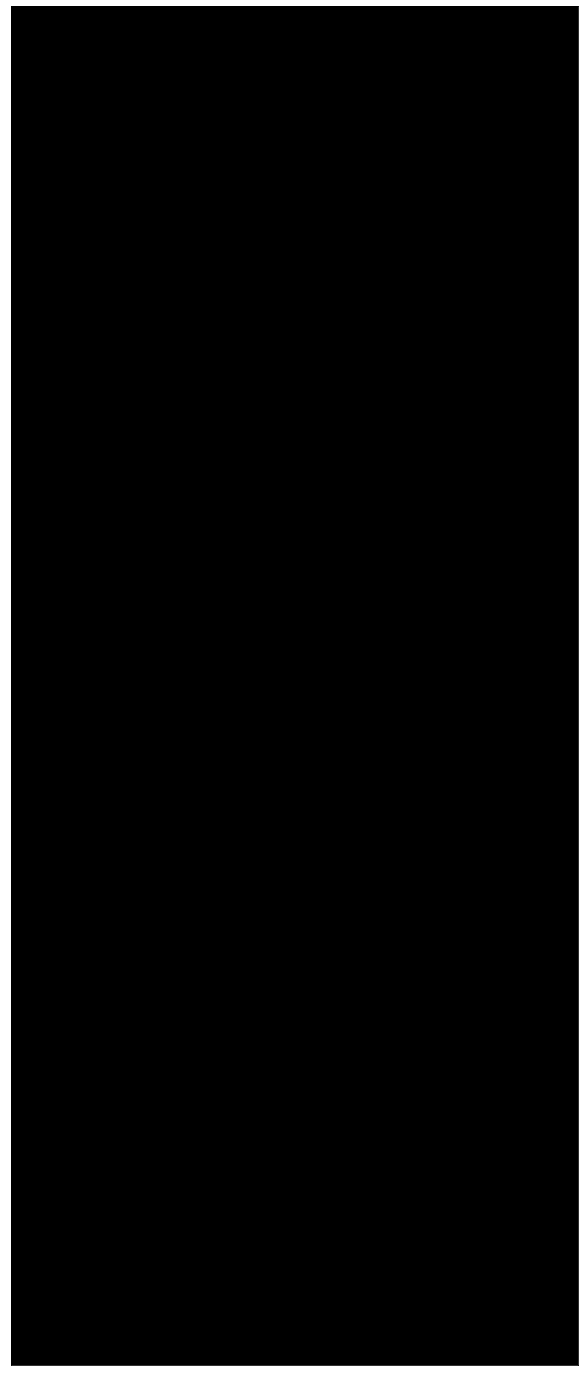

In [46]:


visualize_one_batch(train_data_loader)

Caption: 22314_V O eagle.jpg eagle rampant O
(96, 100, 3)


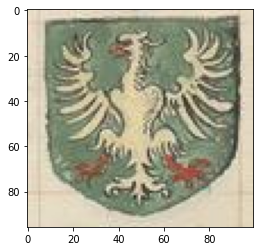

In [47]:
import matplotlib.image as mpimg
i = 8
image_path = images_location +'/'+ df1.iloc[i,0]
print("Caption:", df1.iloc[i,0], df1.iloc[i,1], df.iloc[i,2],df1.iloc[i,3])
img=mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.show()


torch.Size([3, 224, 224])


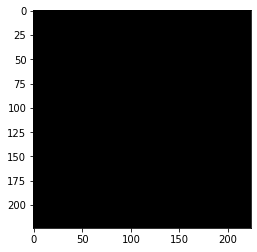

In [48]:
dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
img = images[0]
# print(img)
# img=mpimg.imread(image_path)
print(img.shape)
# plt.imshow(img)
plt.imshow(img.permute(1,2,0))
plt.show()


<class 'torch.Tensor'>


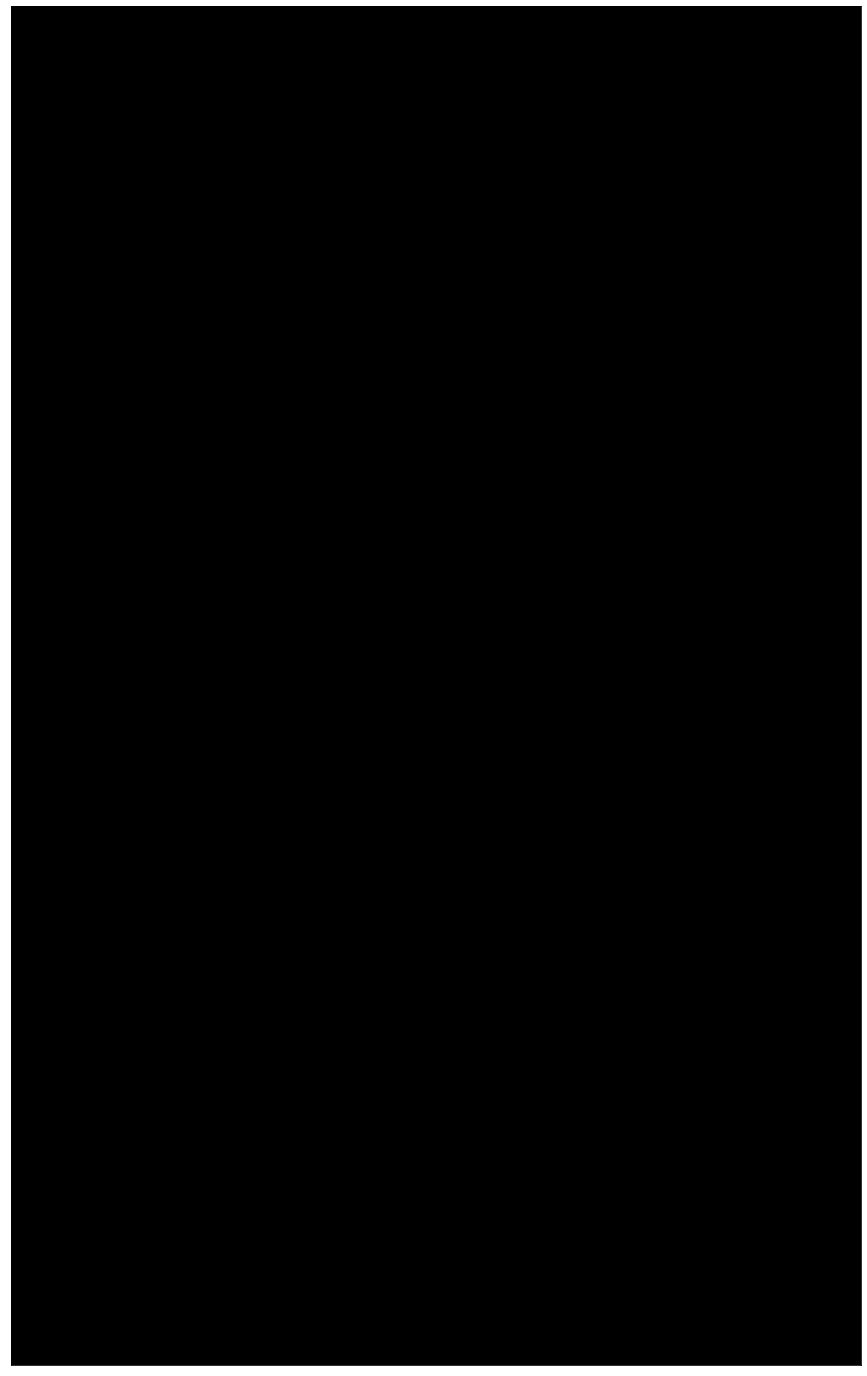

In [49]:
visualize_one_batch(val_data_loader)

# Model Definition

In [50]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)


In [79]:

# from torchviz import make_dot, make_dot_from_trace

# make_dot(model, params=dict(model.named_parameters()))


# Model Training, Validation and Testing

In [88]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 25
CUDA_LAUNCH_BLOCKING=1

In [89]:

model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy = train_classification_model(model,optimizer, criterion, lr_scheduler, epochs, train_data_loader, val_data_loader, device)


Epoch 0:   0%|                                                                | 0/3 [00:00<?, ?batch/s]

Epoch-0 lr: 0.001


Epoch 0: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  4.96batch/s, val_epoch_loss=nan]


** Epoch 0 ** - Epoch Time 1
Train Loss = nan
Train Accuracy = 5.3571333333333335 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 1:   0%|                                                                | 0/3 [00:00<?, ?batch/s]

Epoch-1 lr: 0.001


Epoch 1: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  4.47batch/s, val_epoch_loss=nan]


** Epoch 1 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 2:   0%|                                                                | 0/3 [00:00<?, ?batch/s]

Epoch-2 lr: 0.0001


Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  5.56batch/s, val_epoch_loss=nan]


** Epoch 2 ** - Epoch Time 1
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 3:   0%|                                                                | 0/3 [00:00<?, ?batch/s]

Epoch-3 lr: 0.0001


Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  4.97batch/s, val_epoch_loss=nan]


** Epoch 3 ** - Epoch Time 1
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 4:   0%|                                                                | 0/3 [00:00<?, ?batch/s]

Epoch-4 lr: 1e-05


Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  5.75batch/s, val_epoch_loss=nan]


** Epoch 4 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.3571333333333335 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 5:   0%|                                                                | 0/3 [00:00<?, ?batch/s]

Epoch-5 lr: 1.0000000000000002e-06


Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  5.24batch/s, val_epoch_loss=nan]


** Epoch 5 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.3571333333333335 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 6:   0%|                                                                | 0/3 [00:00<?, ?batch/s]

Epoch-6 lr: 1.0000000000000002e-06


Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  4.88batch/s, val_epoch_loss=nan]


** Epoch 6 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 21.4286 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 7:   0%|                                                                | 0/3 [00:00<?, ?batch/s]

Epoch-7 lr: 1.0000000000000002e-07


Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  4.92batch/s, val_epoch_loss=nan]


** Epoch 7 ** - Epoch Time 1
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 8:   0%|                                                                | 0/3 [00:00<?, ?batch/s]

Epoch-8 lr: 1.0000000000000002e-07


Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  5.71batch/s, val_epoch_loss=nan]


** Epoch 8 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 9:   0%|                                                                | 0/3 [00:00<?, ?batch/s]

Epoch-9 lr: 1.0000000000000004e-08


Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  5.42batch/s, val_epoch_loss=nan]


** Epoch 9 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 10:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-10 lr: 1.0000000000000005e-09


Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.85batch/s, val_epoch_loss=nan]


** Epoch 10 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.3571333333333335 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 11:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-11 lr: 1.0000000000000005e-09


Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.38batch/s, val_epoch_loss=nan]


** Epoch 11 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 12:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-12 lr: 1.0000000000000006e-10


Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.93batch/s, val_epoch_loss=nan]


** Epoch 12 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 13:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-13 lr: 1.0000000000000006e-10


Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.11batch/s, val_epoch_loss=nan]


** Epoch 13 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.3571333333333335 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 14:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-14 lr: 1.0000000000000006e-11


Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.43batch/s, val_epoch_loss=nan]


** Epoch 14 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 15:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-15 lr: 1.0000000000000006e-12


Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.14batch/s, val_epoch_loss=nan]


** Epoch 15 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.3571333333333335 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 16:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-16 lr: 1.0000000000000006e-12


Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.64batch/s, val_epoch_loss=nan]


** Epoch 16 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 17:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-17 lr: 1.0000000000000007e-13


Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.08batch/s, val_epoch_loss=nan]


** Epoch 17 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 21.428566666666665 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 18:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-18 lr: 1.0000000000000007e-13


Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.70batch/s, val_epoch_loss=nan]


** Epoch 18 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 19:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-19 lr: 1.0000000000000008e-14


Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.33batch/s, val_epoch_loss=nan]


** Epoch 19 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 21.4286 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 20:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-20 lr: 1.0000000000000009e-15


Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.29batch/s, val_epoch_loss=nan]


** Epoch 20 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.357166666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 21:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-21 lr: 1.0000000000000009e-15


Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  4.81batch/s, val_epoch_loss=nan]


** Epoch 21 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 21.4286 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 22:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-22 lr: 1.000000000000001e-16


Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.92batch/s, val_epoch_loss=nan]


** Epoch 22 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 21.42856666666667 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 23:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-23 lr: 1.000000000000001e-16


Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.45batch/s, val_epoch_loss=nan]


** Epoch 23 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.3571333333333335 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



Epoch 24:   0%|                                                               | 0/3 [00:00<?, ?batch/s]

Epoch-24 lr: 1.000000000000001e-17


Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  6.06batch/s, val_epoch_loss=nan]


** Epoch 24 ** - Epoch Time 0
Train Loss = nan
Train Accuracy = 5.3571333333333335 % 

Val Loss = nan
Val Accuracy = 10.5263 % 



## Save model to disk

In [41]:

from datetime import datetime

# save the latest model
now = datetime.now() # current date and time
timestr = now.strftime("%m-%d-%Y-%H:%M:%S")
model_full_path = f"{data_location}/classification-model-trained-on-only-real-{timestr}.pth"

model.cpu()
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_epoch_loss,
    'accuracy': train_epoch_accuracy
}

torch.save(model_state, model_full_path)


In [42]:
model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Test model on synthetic data


In [47]:
# load model from disk 
### creat a new model model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)


# model_file_path =  data_location + '/classification-model-plural-full-02-06-2023-09:57:13.pth'
model_file_path =  data_location + '/classification-model-single-full-02-06-2023-20:06:03.pth'
saved_model = torch.load(model_file_path, map_location=torch.device(device))

model.load_state_dict(saved_model['model_state_dict'])
optimizer.load_state_dict(saved_model['optimizer_state_dict'])
criterion = nn.CrossEntropyLoss()

loss = saved_model['loss']
accuracy = saved_model['accuracy']

model, optimizer, loss, accuracy

(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa

In [45]:
#this cell execution from plural classification-model-plural-full-02-06-2023-09:57:13.pth
test_classification_model(model, test_data_loader)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Test Loss = 0.3505
Test Accuracy = 83.81868461538463 % 



In [51]:
#this cell execution from single classification-model-single-full-02-06-2023-20:06:03.pth
import torch
import random
seed = 1234
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


test_classification_model(model, test_data_loader)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Test Loss = 0.9635
Test Accuracy = 75.59526666666666 % 



## Test pretrained model on real data 


In [52]:
# real_data_location =  '/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out/'
real_data_location =  '/home/salnabulsi/coat-of-arms/data/cropped_coas/out/'
# real_caption_file = real_data_location + 'test_real_captions_psumsq.txt'
# new_real_caption_file = real_data_location + '/test_real_labels_psumsq.txt'
# new_real_with_class_caption_file = real_data_location + 'new-test-real-labels-with-class-psumsq.txt'


# real_caption_file = real_data_location + 'test_real_captions_psumsq_single_cleaned.txt'
# new_real_caption_file = real_data_location + '/test_real_labels_psumsq_single_cleaned.txt'
# new_real_with_class_caption_file = real_data_location + 'real_labels_with_class_psumsq_single_cleaned.txt'


real_caption_file = real_data_location + 'test_real_captions_psumsq_single-and-plural_cleaned.txt'
new_real_caption_file = real_data_location + '/test_real_labels_psumsq_single-and-plural_cleaned.txt'
new_real_with_class_caption_file = real_data_location + 'real_labels_with_class_psumsq_single-and-plural_cleaned.txt'


In [ ]:
creat_caption_file(new_real_caption_file, 'image,charge,mod,color,psum,psum_sq')
write_break_down_columns(real_caption_file, new_real_caption_file)


In [53]:
df = pd.read_csv(new_real_caption_file).fillna(MISSING_TOKEN)
df            

,image,charge,mod,color,psum,psum_sq
0,1426_G O 3 lions.jpg,lions,None,O,7.053774e+05,5.096137e+05
1,27623_G A 3 lions.jpg,lions,None,A,7.676897e+05,5.349798e+05
2,3298_O S 3 lions.jpg,lions,None,S,7.240464e+05,4.412956e+05
3,-1_B O 3 lions.jpg,lions,None,O,2.095022e+05,1.465410e+05
4,-1_S O 2 lions passt guard.jpg,lions,passt guard,O,1.387995e+06,8.966109e+05
5,22367_O B 3 lions.jpg,lions,None,B,7.777766e+05,5.546259e+05
6,18885_O S 3 lions passt guard.jpg,lions,passt guard,S,2.817084e+06,1.838050e+06
7,779_O S 3 lions.jpg,lions,None,S,7.574717e+05,5.712754e+05
8,22708_B A 2 lions passt guard.jpg,lions,passt guard,A,8.165868e+05,6.293604e+05
9,2_A S 3 lions.jpg,lions,None,S,8.508724e+05,6.689348e+05


In [ ]:
creat_caption_file(new_real_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')
write_class_colum(df, new_real_with_class_caption_file, CLASSES_MAP)


In [54]:
df_new = pd.read_csv(new_real_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,1426_G O 3 lions.jpg,lions,None,O,7.053774e+05,5.096137e+05,2
1,27623_G A 3 lions.jpg,lions,None,A,7.676897e+05,5.349798e+05,4
2,3298_O S 3 lions.jpg,lions,None,S,7.240464e+05,4.412956e+05,17
3,-1_B O 3 lions.jpg,lions,None,O,2.095022e+05,1.465410e+05,2
4,-1_S O 2 lions passt guard.jpg,lions,passt guard,O,1.387995e+06,8.966109e+05,28
5,22367_O B 3 lions.jpg,lions,None,B,7.777766e+05,5.546259e+05,3
6,18885_O S 3 lions passt guard.jpg,lions,passt guard,S,2.817084e+06,1.838050e+06,27
7,779_O S 3 lions.jpg,lions,None,S,7.574717e+05,5.712754e+05,17
8,22708_B A 2 lions passt guard.jpg,lions,passt guard,A,8.165868e+05,6.293604e+05,31
9,2_A S 3 lions.jpg,lions,None,S,8.508724e+05,6.689348e+05,17


In [55]:
real_images_location = real_data_location + '/resized'

# essentila for calc mean
real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)

In [55]:
# r_mean = get_mean(real_test_dataset, real_test_data_loader, 500 , 500)
# r_std = get_std(real_test_dataset, real_test_data_loader, r_mean, 500 , 500)

# r_mean,r_std 


In [56]:


real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

real_test_random_sampler = RandomSampler(real_test_dataset)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = real_test_random_sampler,
    num_workers = NUM_WORKER,
)


<class 'torch.Tensor'>


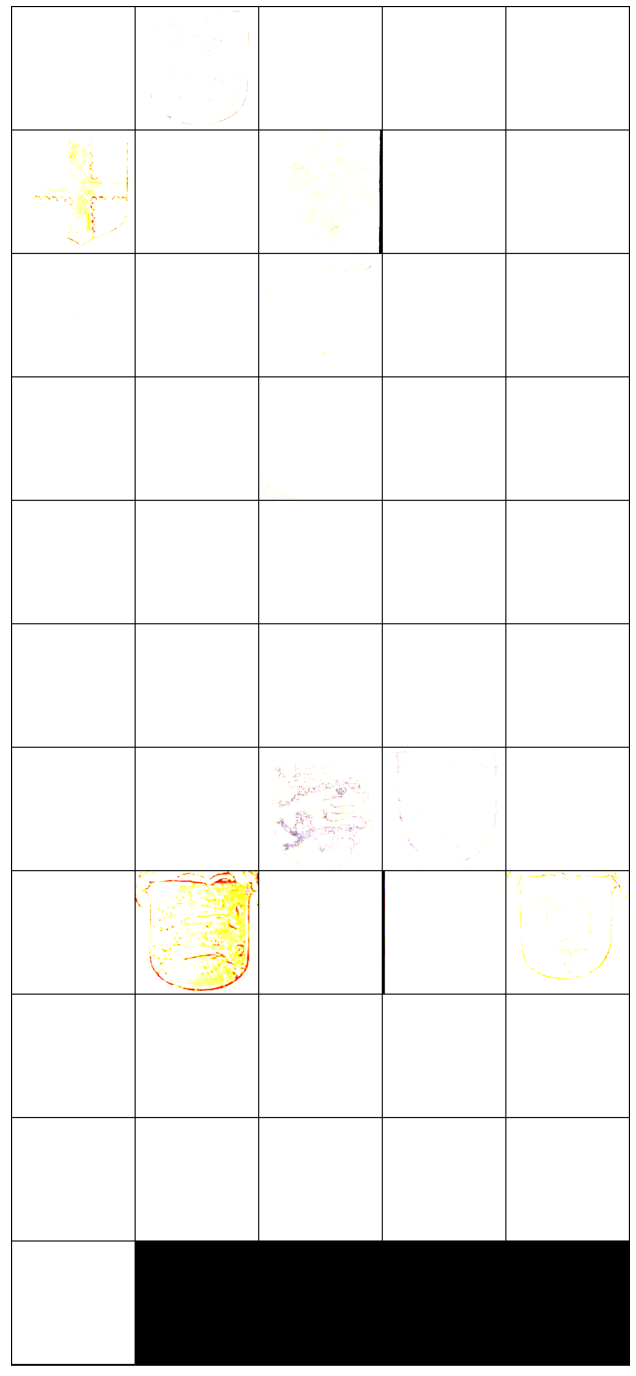

In [57]:

visualize_one_batch(real_test_data_loader)


In [ ]:
# ---------------------- Reproducibility -------------------
# import torch
# import random
# seed = 1234
# random.seed(seed)     # python random generator
# np.random.seed(seed)  # numpy random generator

# torch.manual_seed(seed)
# # torch.cuda.manual_seed_all(seed)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

test_classification_model(model, real_test_data_loader)


<class 'torch.Tensor'>
